In [3]:
import pandas as pd
import json
from geopandas import GeoDataFrame
from shapely.geometry import Point
import numpy as np
import pickle
from matplotlib import pyplot as plt
import jsonlines
from datetime import datetime
%matplotlib inline

In [6]:
data_path = "/Users/alex/Library/CloudStorage/OneDrive-MUNI/Dokumenty/Projects Data/GNNs/cz_traffic/"
#data_path = "/media/sf_bely/OneDrive - MUNI/Dokumenty/Projects Data/GNNs/cz_traffic/"

# Data loading and simple stats

In [73]:
data_df = pd.read_parquet(data_path + 'traffic-2022-02.pqt')
data_df.head()

,timestamp,segment_id,segment_name,segment_road_name,lat,lon,intensity,avg_speed,speed_variance
0,2022-01-17 19:00:00,40000000,D00-001,D0,50.113467,14.587899,9,76.12,55.82
1,2022-01-17 19:00:00,40000000,D00-001,D0,50.113467,14.587899,45,79.09,46.57
2,2022-01-17 19:00:00,40000001,D00-001,D0,50.114363,14.588246,8,84.10,18.19
3,2022-01-17 19:00:00,40000001,D00-001,D0,50.114363,14.588246,38,82.36,25.11
4,2022-01-17 19:00:00,40000010,D00-002,D0,50.102750,14.590411,51,84.88,90.76


In [8]:
# row count
data_df.shape

(10250001, 8)

In [9]:
# unique segments
len(data_df['segment_id'].unique())

2241

In [10]:
len(data_df['segment_name'].unique())

1128

In [134]:
data_df['timestamp'].unique()

array(['2022-01-17T19:00:00.000000000', '2022-01-17T19:15:00.000000000',
       '2022-01-17T19:30:00.000000000', ...,
       '2022-02-18T11:15:00.000000000', '2022-02-18T11:30:00.000000000',
       '2022-02-18T11:45:00.000000000'], dtype='datetime64[ns]')

In [136]:
data_df.groupby(['timestamp', 'segment_name']).agg({'segment_id': lambda x: len(x)})

segment_id
timestamp           segment_name            
2022-01-17 19:00:00 D00-001                4
                    D00-002                4
                    D00-003                4
                    D00-004                4
                    D00-005                4
...                                      ...
2022-02-18 11:45:00 I38-052                2
                    I38-053                2
                    I38-054                2
                    I38-055                2
                    I38-056                2

[3164126 rows x 1 columns]

# Segments and locations

In [74]:
# segments with locations
segments = data_df[['segment_id', 'lat', 'lon']].drop_duplicates()
segments

,segment_id,lat,lon
0,40000000,50.113467,14.587899
2,40000001,50.114363,14.588246
4,40000010,50.102750,14.590411
6,40000011,50.110105,14.588064
8,40000020,50.092003,14.594524
...,...,...,...
1551775,40015231,50.072486,14.751264
4997412,40015120,49.660566,18.343925
5027141,40015121,49.661861,18.338461
7695212,40015140,49.675312,18.322392


In [75]:
geometry = [Point(xy) for xy in zip(segments.lon, segments.lat)]
segments_gdf = GeoDataFrame(segments, crs="EPSG:4326", geometry=geometry)

Text(0.5, 1.0, 'segment locations')

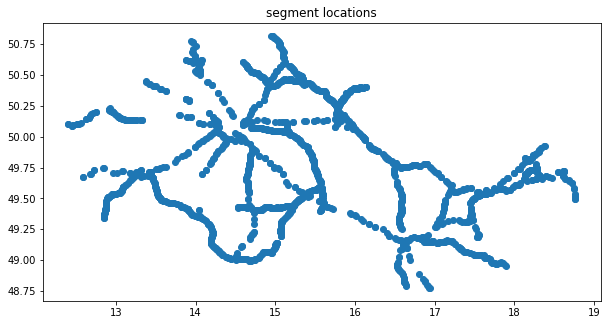

In [13]:
# plot segments
ax = segments_gdf.plot(figsize=(10, 10))
ax.set_title('segment locations')

## Avg speed

In [14]:
# avg speed stats
data_df['avg_speed'].describe()

count    1.025000e+07
mean     7.881881e+01
std      1.037797e+01
min      0.000000e+00
25%      7.371000e+01
50%      8.187000e+01
75%      8.637000e+01
max      1.651600e+02
Name: avg_speed, dtype: float64

In [15]:
segment_avgSpd = data_df.groupby('segment_id').agg({'avg_speed': 'mean'})
avg_speed = segments_gdf.merge(segment_avgSpd, on='segment_id')

In [16]:
avg_speed.head()

,segment_id,lat,lon,geometry,avg_speed
0,40000000,50.113467,14.587899,POINT (14.58790 50.11347),75.532681
1,40000001,50.114363,14.588246,POINT (14.58825 50.11436),79.387276
2,40000010,50.102750,14.590411,POINT (14.59041 50.10275),82.900669
3,40000011,50.110105,14.588064,POINT (14.58806 50.11010),75.886416
4,40000020,50.092003,14.594524,POINT (14.59452 50.09200),76.412280


Text(0.5, 1.0, 'avg speed by segment')

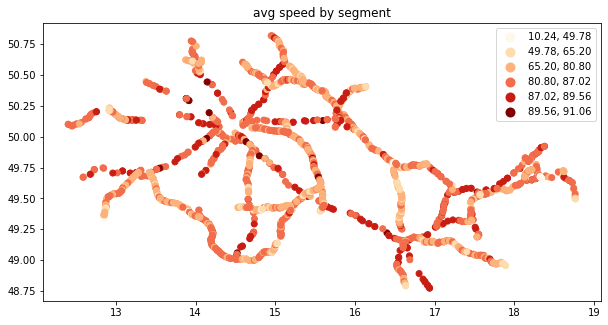

In [18]:
ax = avg_speed.plot(column='avg_speed', cmap='OrRd', k=10, scheme='Percentiles', figsize=(10, 10), legend=True)
ax.set_title('avg speed by segment')

## Avg intensity

In [19]:
# plot avg intensity by segments
segment_avgIntensity = data_df.groupby('segment_id').agg({'intensity': 'mean'})
avg_intensity = segments_gdf.merge(segment_avgIntensity, on='segment_id')

Text(0.5, 1.0, 'avg intensity by segment')

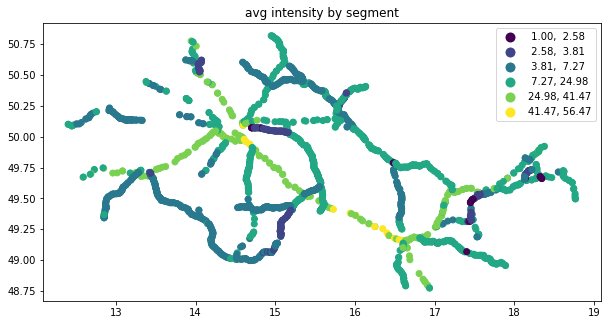

In [20]:
ax = avg_intensity.plot(column='intensity', k=10, scheme='Percentiles', figsize=(10, 10), legend=True)
ax.set_title('avg intensity by segment')

In [21]:
totalIntensity = data_df['intensity']
totalIntensity.describe()

count    1.025000e+07
mean     1.144768e+01
std      1.752265e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.300000e+01
max      2.750000e+02
Name: intensity, dtype: float64

Text(0.5, 1.0, 'intensity distribution over the observed month')

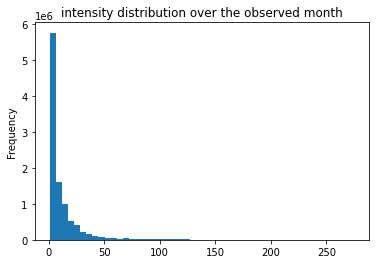

In [22]:
totalIntensity.plot.hist(bins=50)
plt.title('intensity distribution over the observed month')

In [29]:
data_df['hour'] = data_df['timestamp'].apply(lambda x: x.hour)
data_df['week_day'] = data_df['timestamp'].apply(lambda x: x.dayofweek)

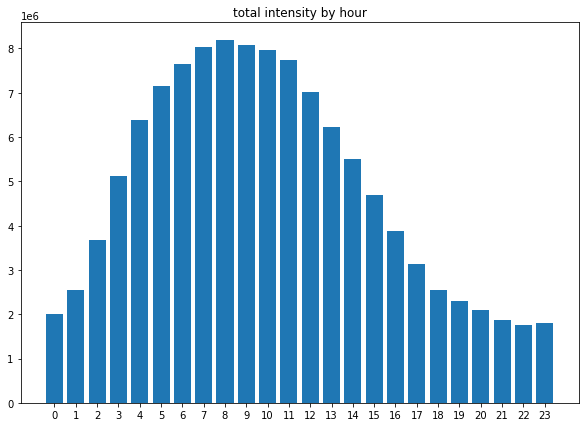

In [34]:
df_hour = data_df.groupby('hour').agg({'intensity':'sum'})
plt.figure(figsize=(10, 7))
plt.bar(df_hour.index, df_hour['intensity'])
plt.title('total intensity by hour')
plt.xticks(range(0, 24));

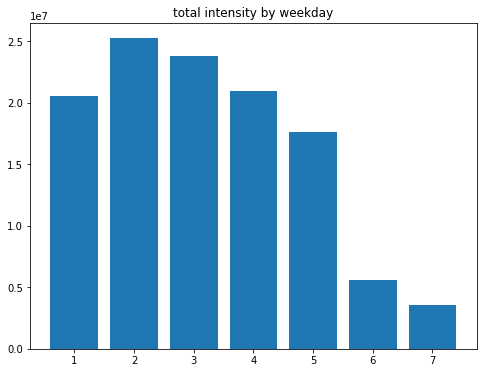

In [51]:
df_week = data_df.groupby('week_day').agg({'intensity':'sum'})
plt.figure(figsize=(8, 6))
plt.bar(df_week.index+1, df_week['intensity'])
plt.title('total intensity by weekday')
plt.xticks(range(1, 8));

# Understanding segment names/roads etc.

In [52]:
data_df.head()

,timestamp,segment_id,segment_name,lat,lon,intensity,avg_speed,speed_variance,hour,week_day
0,2022-01-17 19:00:00,40000000,D00-001,50.113467,14.587899,9,76.12,55.82,19,0
1,2022-01-17 19:00:00,40000000,D00-001,50.113467,14.587899,45,79.09,46.57,19,0
2,2022-01-17 19:00:00,40000001,D00-001,50.114363,14.588246,8,84.10,18.19,19,0
3,2022-01-17 19:00:00,40000001,D00-001,50.114363,14.588246,38,82.36,25.11,19,0
4,2022-01-17 19:00:00,40000010,D00-002,50.102750,14.590411,51,84.88,90.76,19,0


In [65]:
# check segment names and attached segment ids
segment_names = data_df.groupby('segment_name').agg({'segment_id': lambda x: set(x)})

In [66]:
segment_names

,segment_id
segment_name,
D00-001,"{40000000, 40000001}"
D00-002,"{40000010, 40000011}"
D00-003,"{40000020, 40000021}"
D00-004,"{40000030, 40000031}"
D00-005,"{40000040, 40000041}"
...,...
I58-014,"{40015170, 40015171}"
I63-001,"{40010700, 40010701}"
I63-002,"{40010710, 40010711}"


In [139]:
segment_names.loc['D04-012']

segment_id    {40012221}
Name: D04-012, dtype: object

In [140]:
segments[segments.segment_id == 40012221]

,segment_id,lat,lon,geometry
3500,40012221,49.869908,14.269801,POINT (14.26980 49.86991)


In [69]:
# check ids for a segment name D00-001
segments[segments.segment_id == 40000000]

,segment_id,lat,lon,geometry
0,40000000,50.113467,14.587899,POINT (14.58790 50.11347)


In [137]:
segments_gdf[segments_gdf.segment_id == 40000001]

,segment_id,lat,lon,geometry
2,40000001,50.114363,14.588246,POINT (14.58825 50.11436)


Text(0.5, 1.0, 'segment locations')

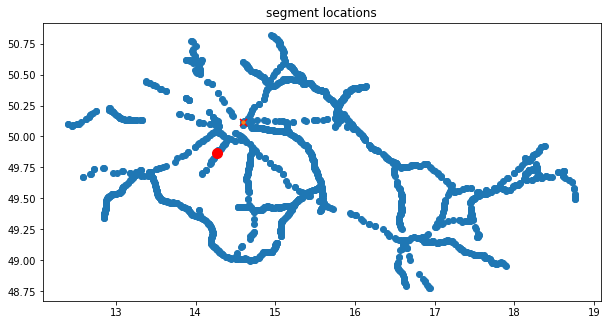

In [141]:
# plot segments attached with a segment name 
ax = segments_gdf.plot(figsize=(10, 10))
segments_gdf[segments_gdf.segment_id == 40000000].plot(color='red', marker='x', markersize=50, ax=ax)
segments_gdf[segments_gdf.segment_id == 40000001].plot(marker='o', markersize=10, ax=ax)
segments_gdf[segments_gdf.segment_id == 40012221].plot(color='red', marker='o', markersize=100, ax=ax)
ax.set_title('segment locations')

In [ ]:
# most segment names seem to have 2 segment ids associated with it, which seems to be overlapping, 

In [76]:
# segment name with locations
segment_name = data_df[['segment_name', 'segment_road_name', 'lat', 'lon']].drop_duplicates(subset=['segment_name'])
geometry = [Point(xy) for xy in zip(segment_name.lon, segment_name.lat)]
segment_name_gdf = GeoDataFrame(segment_name, crs="EPSG:4326", geometry=geometry)

Text(0.5, 1.0, 'segment name locations')

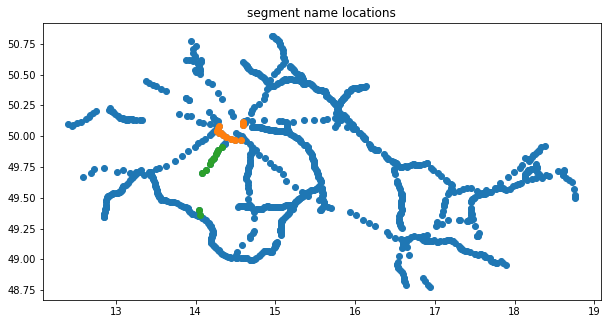

In [77]:
# plot segments
ax = segment_name_gdf.plot(figsize=(10, 10))
segment_name_gdf[segment_name_gdf.segment_road_name == 'D0'].plot(figsize=(10, 10), ax=ax)
segment_name_gdf[segment_name_gdf.segment_road_name == 'D4'].plot(figsize=(10, 10), ax=ax)
ax.set_title('segment name locations')

In [78]:
segment_name_gdf.segment_road_name.unique()

array(['D0', 'D1', 'D10', 'D11', 'D2', 'D3', 'D35', 'D4', 'D46', 'D48',
       'D5', 'D52', 'D55', 'D56', 'D6', 'D7', 'D8', '11', '12', '16',
       '19', '20', '26', '3', '30', '33', '34', '35', '37', '38', '4',
       '43', '46', '47', '48', '50', '52', '55', '58', '6', '63', '7'],
      dtype=object)

In [81]:
segment_name_gdf.segment_name.unique()

array(['D00-001', 'D00-002', 'D00-003', ..., 'D07-012', 'D48-011',
       'D56-007'], dtype=object)

In [79]:
#segment_name_gdf.to_csv('czech_roads.csv', index=False)

# Make and visualize the network

In [80]:
connections = pd.DataFrame({'segment_from':['D00-015', 'D05-017','I26-005', 
                                   'D05-014', 'D06-008', 'D07-006', 'I07-001', 'D07-001', 'D00-015', 'D06-001', 
                                   'D05-001', 'D05-001', 'I04-001', 'I04-001', 'D00-004', 'D00-004', 
                                   'I03-001', 'I03-001', 'D04-011', 'D04-011', 'I20-088', 'D03-013', 
                                   'D03-013', 'I19-011', 'I19-011', 'D03-001', 'D11-001', 'D11-001', 'D10-001', 
                                   'I12-001', 'I38-025', 'I38-025', 'I12-029', 'I12-029', 'I34-092', 
                                   'I34-092', 'D01-020', 'D01-020', 'D01-018', 'D01-018', 'D35-001', 
                                   'D35-001', 'I11-001', 'I11-001', 'D11-013', 'D11-013', 'I11-004', 'I35-071', 
                                   'I35-071', 'D35-016', 'D35-016', 'D02-001', 'D02-001', 'I52-001', 
                                   'I52-001', 'I50-001', 'I50-001', 'I43-038', 'I43-038', 'D46-001', 
                                   'D46-001', 'I35-126', 'D46-011', 'D46-011', 'I46-001', 'D35-008', 
                                   'D35-008', 'I35-124', 'D01-051', 'D01-051', 'D35-013', 'D48-001', 
                                   'D48-001', 'I58-013', 'I58-013', 'D56-007', 'D56-007', 'I11-005', 
                                   'I11-020', 'I11-020'],
                            'segment_to':['D06-001', 'I26-005', 'D05-016', 'I20-005', 'I06-025', 'I07-002', 'D07-005', 
                            'D00-015', 'D06-001', 'D00-014', 'D00-012', 'D00-013', 'D00-007', 'D00-006', 
                            'D01-005', 'D01-004', 'D01-008', 'D01-007', 'I20-052', 'I20-053', 'I34-001', 
                            'I34-001', 'I34-002', 'D03-003', 'D03-002', 'I03-027', 'D00-003', 'D00-002', 
                            'D00-001', 'D00-003', 'D11-006', 'D11-005', 'I38-033', 'I38-034', 'I38-079', 
                            'I38-080', 'I38-093', 'I38-092', 'I34-077', 'I34-078', 'D11-012', 'D11-011', 
                            'D11-012', 'D11-013', 'I35-071', 'I35-070', 'I33-001', 'I33-001', 'I11-004', 
                            'I35-079', 'I35-080', 'D01-032', 'D01-033', 'D01-032', 'D01-031', 'D01-037', 
                            'D01-038', 'I35-106', 'I35-105', 'D01-040', 'D01-041', 'D35-007', 'D35-007', 
                            'I46-001', 'D35-007', 'I46-001', 'D46-011', 'D35-002', 'D35-013', 'D01-050', 
                            'D01-050', 'D01-052', 'D01-053', 'D48-008', 'D48-007', 'D48-003', 'D48-011', 
                            'D48-006', 'D01-058', 'D01-059']})
connections

,segment_from,segment_to
0,D00-015,D06-001
1,D05-017,I26-005
2,I26-005,D05-016
3,D05-014,I20-005
4,D06-008,I06-025
...,...,...
75,D56-007,D48-003
76,D56-007,D48-011
77,I11-005,D48-006
78,I11-020,D01-058


In [144]:
road = 'D4'
segment_name_gdf[segment_name_gdf.segment_road_name == road]

,segment_name,segment_road_name,lat,lon,geometry
494,D04-001,D4,49.911785,14.336555,POINT (14.33656 49.91178)
496,D04-002,D4,49.886854,14.282595,POINT (14.28260 49.88685)
500,D04-004,D4,49.824431,14.228866,POINT (14.22887 49.82443)
504,D04-005,D4,49.815497,14.219902,POINT (14.21990 49.81550)
508,D04-006,D4,49.798255,14.196610,POINT (14.19661 49.79826)
510,D04-007,D4,49.776509,14.185656,POINT (14.18566 49.77651)
513,D04-008,D4,49.726380,14.126752,POINT (14.12675 49.72638)
517,D04-009,D4,49.700581,14.081306,POINT (14.08131 49.70058)
521,D04-010,D4,49.404316,14.040890,POINT (14.04089 49.40432)
524,D04-011,D4,49.360780,14.055477,POINT (14.05548 49.36078)


In [149]:
road_temp = segment_name_gdf[segment_name_gdf.segment_road_name == road]
road_temp['segment_from'] = road_temp[['segment_name']].shift()
road_temp.rename(columns={'segment_name':'segment_to'}, inplace=True)
within_roads = []
within_roads.append(road_temp[['segment_from', 'segment_to']])
segment_connections = pd.concat(within_roads)
segment_connections.dropna(inplace=True)
segment_connections.reset_index(drop=True, inplace=True)
segment_connections

/Users/alex/.virtualenvs/main_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alex/.virtualenvs/main_env/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,segment_from,segment_to
0,D04-001,D04-002
1,D04-002,D04-004
2,D04-004,D04-005
3,D04-005,D04-006
4,D04-006,D04-007
5,D04-007,D04-008
6,D04-008,D04-009
7,D04-009,D04-010
8,D04-010,D04-011
9,D04-011,D04-012


In [158]:
within_roads = []
for road in segment_name_gdf.segment_road_name.unique():
    road_temp = segment_name_gdf[segment_name_gdf.segment_road_name == road]
    road_temp['segment_from'] = road_temp[['segment_name']].shift()
    road_temp.rename(columns={'segment_name':'segment_to'}, inplace=True)
    within_roads.append(road_temp[['segment_from', 'segment_to']])

/Users/alex/.virtualenvs/main_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alex/.virtualenvs/main_env/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [159]:
within_roads.append(connections)
segment_connections = pd.concat(within_roads)
segment_connections.dropna(inplace=True)
segment_connections.reset_index(drop=True, inplace=True)
segment_connections

,segment_from,segment_to
0,D00-001,D00-002
1,D00-002,D00-003
2,D00-003,D00-004
3,D00-004,D00-005
4,D00-005,D00-006
...,...,...
1161,D56-007,D48-003
1162,D56-007,D48-011
1163,I11-005,D48-006
1164,I11-020,D01-058


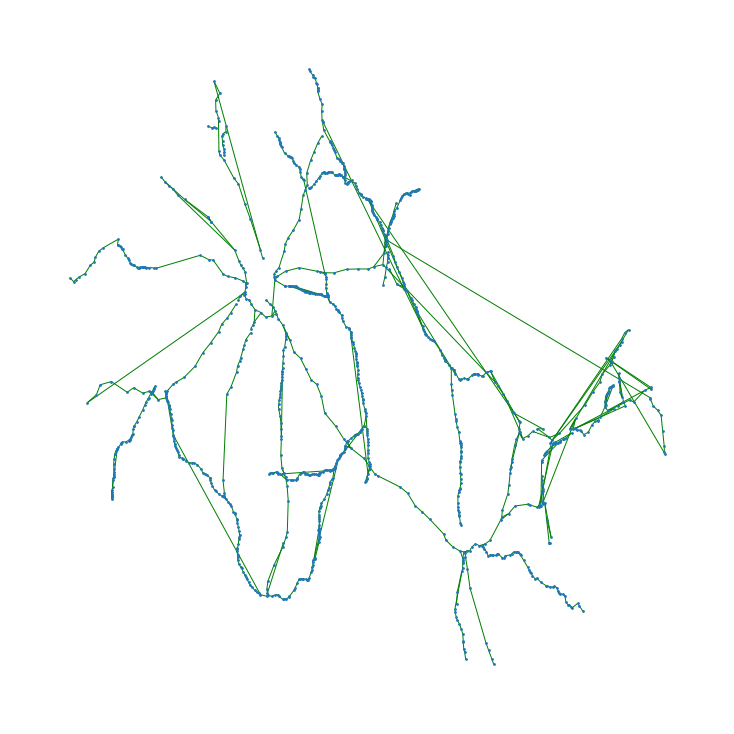

In [161]:
import networkx as nx

#create road network
segments_graph = nx.Graph()
for i in segment_connections.index:
    segments_graph.add_edge(segment_connections.segment_from[i], segment_connections.segment_to[i])   
    
#create a dictionary of segment locations
segment_position_dict = {segment_name_gdf.segment_name[c]:(segment_name_gdf.lon[c], segment_name_gdf.lat[c]) for c in segment_name_gdf.index}

segments_graph.remove_edge('D06-017', 'D06-018')
segments_graph.remove_edge('D06-007', 'D06-008')
segments_graph.remove_edge('D06-006', 'D06-007')
segments_graph.remove_edge('I07-002', 'I07-003')
segments_graph.remove_edge('I35-129', 'I35-128')
segments_graph.remove_edge('D35-015', 'D35-014')
segments_graph.remove_edge('I35-140', 'I35-141')
segments_graph.remove_edge('D04-012', 'D04-011')
segments_graph.remove_edge('D04-002', 'D04-004')
segments_graph.add_edge('D04-002', 'D04-012')
segments_graph.add_edge('D04-012', 'D04-003')
segments_graph.add_edge('D04-003', 'D04-004')
segments_graph.add_edge('D06-007', 'D06-021')
segments_graph.add_edge('D06-007', 'I06-001')
segments_graph.add_edge('D06-006', 'D06-018')
segments_graph.add_edge('I07-003', 'D07-010')
#visualize the road newtork
plt.figure(figsize = (10,10))
nx.draw(segments_graph, pos=segment_position_dict, with_labels=False, arrows=False, node_size=3, width=1, edge_color='green')

In [ ]:
segments_graph_df = nx.to_pandas_edgelist(segments_graph)
segments_graph_df = segments_graph_df.rename(columns={'source':'segment_from', 'target':'segment_to'})
#segments_graph_df.to_csv('czech_road_connections.csv', index=False)

In [ ]:
with open("czech_road_network.p", 'wb') as f:
    pickle.dump(segments_graph, f)
    
with open("czech_road_network.p", 'rb') as f:  # notice the r instead of w
    G_loaded = pickle.load(f)

# Repeated locations

In [111]:
# check for a particular segment full name

segments_gdf[segments_gdf.segment_id == 40001281]

,segment_id,lat,lon,geometry
456,40001281,50.142684,15.759507,POINT (15.75951 50.14268)


In [112]:
segments_gdf[segments_gdf.segment_id == 40015321]

,segment_id,lat,lon,geometry
1543733,40015321,50.142684,15.759507,POINT (15.75951 50.14268)


In [ ]:
# repeated location

In [113]:
# check another

segments_gdf[segments_gdf.segment_id == 40015320]

,segment_id,lat,lon,geometry
1543731,40015320,50.145381,15.750391,POINT (15.75039 50.14538)


In [114]:
segments_gdf[segments_gdf.segment_id == 40001280]

,segment_id,lat,lon,geometry
454,40001280,50.145381,15.750391,POINT (15.75039 50.14538)


In [ ]:
# another repeated


In [116]:
# roads
len(data_df['segment_road_name'].unique())

42

In [117]:
# roads with segment ids
roads = data_df.groupby('segment_road_name').agg({'segment_id': lambda x: set(x)})
roads

,segment_id
segment_road_name,
11,"{40002561, 40002570, 40002571, 40002450, 40002..."
12,"{40002690, 40002691, 40002820, 40002821, 40002..."
16,"{40003200, 40003201, 40002950, 40002951, 40003..."
19,"{40003590, 40003591, 40003610, 40003611, 40003..."
20,"{40004100, 40004101, 40004110, 40004111, 40004..."
26,"{40004610, 40004611, 40004620, 40004621, 40004..."
3,"{40005120, 40005121, 40005250, 40005251, 40005..."
30,"{40005280, 40005281, 40005320, 40005321, 40005..."
33,"{40005380, 40005381, 40005390, 40005391, 40005..."


In [118]:
# roads with segment names
roads = data_df.groupby('segment_road_name').agg({'segment_name': lambda x: set(x)})
roads

,segment_name
segment_road_name,
11,"{I11-008, I11-011, I11-018, I11-017, I11-016, ..."
12,"{I12-030, I12-008, I12-004, I12-017, I12-028, ..."
16,"{I16-021, I16-016, I16-026, I16-014, I16-033, ..."
19,"{I19-024, I19-003, I19-020, I19-019, I19-002, ..."
20,"{I20-078, I20-026, I20-054, I20-060, I20-042, ..."
26,"{I26-024, I26-015, I26-008, I26-028, I26-045, ..."
3,"{I03-007, I03-004, I03-021, I03-008, I03-016, ..."
30,"{I30-007, I30-008, I30-003, I30-004, I30-006, ..."
33,"{I33-018, I33-025, I33-015, I33-024, I33-023, ..."


In [119]:
# roads with locations
roads = data_df[['segment_road_name', 'lat', 'lon']].drop_duplicates()
roads

,segment_road_name,lat,lon
0,D0,50.113467,14.587899
2,D0,50.114363,14.588246
4,D0,50.102750,14.590411
6,D0,50.110105,14.588064
8,D0,50.092003,14.594524
...,...,...,...
1551775,12,50.072486,14.751264
4997412,D48,49.660566,18.343925
5027141,D48,49.661861,18.338461
7695212,D56,49.675312,18.322392


Text(0.5, 1.0, 'avg intensity by road')

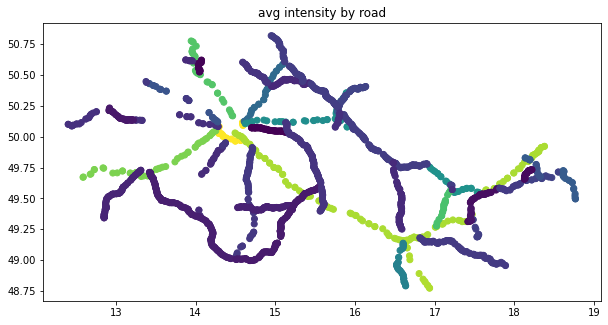

In [131]:
# avg intensity by road

roads_avgInt = data_df.groupby('segment_road_name').agg({'intensity': 'mean'})
geometry = [Point(xy) for xy in zip(roads.lon, roads.lat)]
roads_gdf = GeoDataFrame(roads, crs="EPSG:4326", geometry=geometry)
roads_avgIntensity = roads_gdf.merge(roads_avgInt, on='segment_road_name')
roads_avgIntensity.plot(column='intensity', k=2, figsize=(10, 10))#, legend=True, scheme='Percentiles')
plt.title('avg intensity by road')

Text(0.5, 1.0, 'avg speed by road')

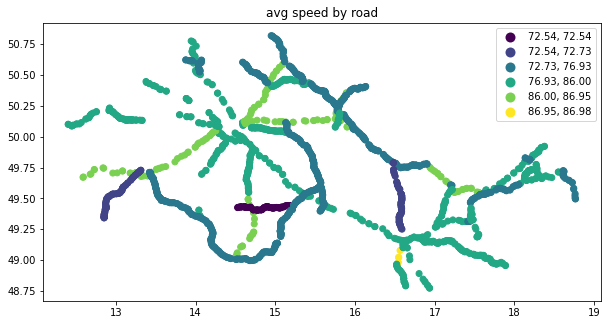

In [133]:
# avg speed by road

roads_avgSp = data_df.groupby('segment_road_name').agg({'avg_speed': 'mean'})
roads_avgSpeed = roads_gdf.merge(roads_avgSp, on='segment_road_name')
roads_avgSpeed.plot(column='avg_speed', k=10, scheme='Percentiles', figsize=(10, 10), legend=True)
plt.title('avg speed by road')

# 15 min data aggregation (OLD code)

In [ ]:
seconds = 900
epoch = (col("timestamp").cast("timestamp").cast("bigint") / seconds).cast(
    "bigint"
) * seconds

In [ ]:
df_1 = df.withColumn("epoch", epoch)

In [ ]:
df_1 = df_1.withColumn("intensity", df_1["intensity"].cast(IntegerType()))

In [ ]:
min_epoch, max_epoch = df_1.select(min("epoch"), max("epoch")).first()

ref = spark.range(min_epoch, max_epoch + seconds, seconds).toDF("epoch")

In [ ]:
(
    ref.join(df_1, "epoch", "left")
    .withColumn("ts_resampled", timestamp_seconds("epoch"))
    .groupBy("segment_name", "ts_resampled")
    .sum("intensity")
    .orderBy("ts_resampled")
    .fillna(0, subset=["sum(intensity)"])
    .show(truncate=False)
)

22/08/17 19:25:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/17 19:25:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
+------------+-------------------+--------------+
|segment_name|ts_resampled       |sum(intensity)|
+------------+-------------------+--------------+
|D00-001     |2022-01-18 00:30:00|100           |
|D00-002     |2022-01-18 00:30:00|108           |
|D00-003     |2022-01-18 00:30:00|123           |
|D00-004     |2022-01-18 00:30:00|134           |
|D00-005     |2022-01-18 00:30:00|138           |
|D00-006     |2022-01-18 00:30:00|122           |
|D00-007     |2022-01-18 00:30:00|132           |
|D00-008     |2022-01-18 00:30:00|130           |
|D00-009     |2022-01-18 00:30:00|121           |
|D00-010     |2022-01-18 00:30:00|111           |
|D00-011     |2022-01-18 00:30:00|120           |
|D00-012     |2022-01-18 00:30:00|111           |
|D00-013     |20

In [ ]:
df_1

DataFrame[avg_speed: string, intensity: int, segment_fullname: string, segment_id: string, segment_location: struct<lat:string,lon:string>, segment_name: string, segment_road_name: string, speed_variance: string, timestamp: string, epoch: bigint]

In [ ]:
df_ = (
    ref.join(df_1, "epoch", "left")
    .withColumn("ts_resampled", timestamp_seconds("epoch"))
    .groupBy("segment_name", "ts_resampled")
    .sum("intensity")
    .orderBy("ts_resampled")
    .fillna(0, subset=["sum(intensity)"])
)

In [ ]:
df_.show()

22/08/17 19:37:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/17 19:37:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
+------------+-------------------+--------------+
|segment_name|       ts_resampled|sum(intensity)|
+------------+-------------------+--------------+
|     D00-001|2022-01-18 00:30:00|           100|
|     D00-002|2022-01-18 00:30:00|           108|
|     D00-003|2022-01-18 00:30:00|           123|
|     D00-004|2022-01-18 00:30:00|           134|
|     D00-005|2022-01-18 00:30:00|           138|
|     D00-006|2022-01-18 00:30:00|           122|
|     D00-007|2022-01-18 00:30:00|           132|
|     D00-008|2022-01-18 00:30:00|           130|
|     D00-009|2022-01-18 00:30:00|           121|
|     D00-010|2022-01-18 00:30:00|           111|
|     D00-011|2022-01-18 00:30:00|           120|
|     D00-012|2022-01-18 00:30:00|           111|
|     D00-013|20

In [ ]:
df_

DataFrame[segment_name: string, ts_resampled: timestamp, sum(intensity): bigint]

In [ ]:
df__ = df_.groupBy("ts_resampled").pivot('segment_name').agg(sum('sum(intensity)'))

In [ ]:
df1 = df__.select('ts_resampled', 'D00-001').toPandas()

22/08/18 09:50:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/18 09:50:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/18 09:50:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/18 09:50:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [ ]:
df1

,ts_resampled,D00-001
0,2022-01-18 00:30:00,100
1,2022-01-18 00:45:00,118
2,2022-01-18 01:00:00,81
3,2022-01-18 01:15:00,68
4,2022-01-18 01:30:00,80
...,...,...
3039,2022-02-14 05:15:00,68
3040,2022-02-14 05:30:00,80
3041,2022-02-14 05:45:00,83
3042,2022-02-14 06:00:00,86
